# **3D Shapes Dataset**

**Imports**

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
from tqdm import tqdm, trange
import os

In [2]:
base_dir = os.path.abspath('../..')
data_dir = os.path.join(base_dir,'data')

In [4]:
10*8*15*4

4800

In [4]:
list(range(3))

[0, 1, 2]

**Load dataset**

In [5]:
# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [6]:
a = images[np.argwhere(labels[:,4] == 3)]
a.shape

(120000, 64, 64, 3)

In [7]:
images.shape
1/5

0.2

In [64]:
# np.random.seed(seed=711)
base_set_dir = os.path.join(data_dir,'base_set')
overlap_50_dir = os.path.join(data_dir,'overlap_50_set')
overlap_20_dir = os.path.join(data_dir,'overlap_20_set')
validation_dir = os.path.join(data_dir,'validation_set')

base_set_labs=[]
overlap_50_labs=[]
overlap_20_labs=[]
validation_labs = []

for i in trange(4):
    shape_inds = np.argwhere(labels[:,4] == i)
    np.random.seed(seed=i)
    sub_inds = np.random.choice(shape_inds.flatten(),10000,replace=False)
    for ind,j in tqdm(enumerate(sub_inds[0:5000])):
        if not os.path.exists(base_set_dir):
            os.makedirs(base_set_dir)
        plt.imsave(os.path.join(base_set_dir,f'shape_{i}_{j}.png'),images[j,:,:,:],format='png')
        base_set_labs.append(i)
        if ind<2500:
            if not os.path.exists(overlap_50_dir):
                os.makedirs(overlap_50_dir)
            plt.imsave(os.path.join(overlap_50_dir,f'shape_{i}_{j}.png'),images[j,:,:,:],format='png')
            overlap_50_labs.append(i)
        if ind<1000:
            if not os.path.exists(overlap_20_dir):
                os.makedirs(overlap_20_dir)
            plt.imsave(os.path.join(overlap_20_dir,f'shape_{i}_{j}.png'),images[j,:,:,:],format='png')
            overlap_20_labs.append(i)
    for ind,j in tqdm(enumerate(sub_inds[5000:])):
        if ind<4000:
            plt.imsave(os.path.join(overlap_20_dir,f'shape_{i}_{j}.png'),images[j,:,:,:],format='png')
            overlap_20_labs.append(i)
        if ind<2500:
            plt.imsave(os.path.join(overlap_50_dir,f'shape_{i}_{j}.png'),images[j,:,:,:],format='png')
            overlap_50_labs.append(i)
        if ind<4000:
            if not os.path.exists(validation_dir):
                os.makedirs(validation_dir)
            plt.imsave(os.path.join(validation_dir,f'shape_{i}_{j}.png'),images[j,:,:,:],format='png')
            validation_labs.append(i)

        
            


5000it [41:42,  2.00it/s]00<?, ?it/s]
5000it [50:51,  1.64it/s]
438it [06:34,  1.11it/s]32:34<4:37:42, 5554.24s/it]
 25%|██▌       | 1/4 [1:39:08<4:57:26, 5948.82s/it]


KeyboardInterrupt: 

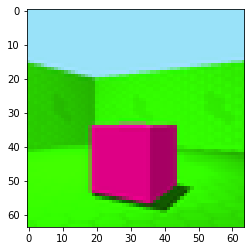

In [58]:
plt.imshow(images[j,:,:,:])

In [61]:
a = [1,2,3,4,5,6,7,8,9,10]

for i,j in tqdm(enumerate(a)):
    print(i,j)

10it [00:00, 16750.42it/s]

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10


In [41]:
plt.imsave(data_dir+'test.png',images[sorted(inds[0:10]),:,:,:][1])


if not os.path.exists(directory):
    os.makedirs(directory)

In [47]:
np.random.seed(seed=711)
print(np.random.choice(np.argwhere(labels[:,4] == 2).flatten(),10000,replace=False))
np.random.seed(seed=711)
print(np.random.choice(np.argwhere(labels[:,4] == 2).flatten(),10000,replace=False))

[307483 287617 189694 ... 314556 407136 127962]
[307483 287617 189694 ... 314556 407136 127962]


**Methods for sampling unconditionally/conditionally on a given factor**

In [22]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_random_batch(batch_size):
  """ Samples a random batch of images.
  Args:
    batch_size: number of images to sample.

  Returns:
    batch: images shape [batch_size,64,64,3].
  """
  indices = np.random.choice(n_samples, batch_size)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])

**Helper function to show images**


In [23]:
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

**Examples**

In [26]:
batch_size = 15
img_batch = sample_batch(batch_size,[3,4],[0.5,3])
show_images_grid(img_batch,15)

ValueError: shape mismatch: value array of shape (2,) could not be broadcast to indexing result of shape (2,15)

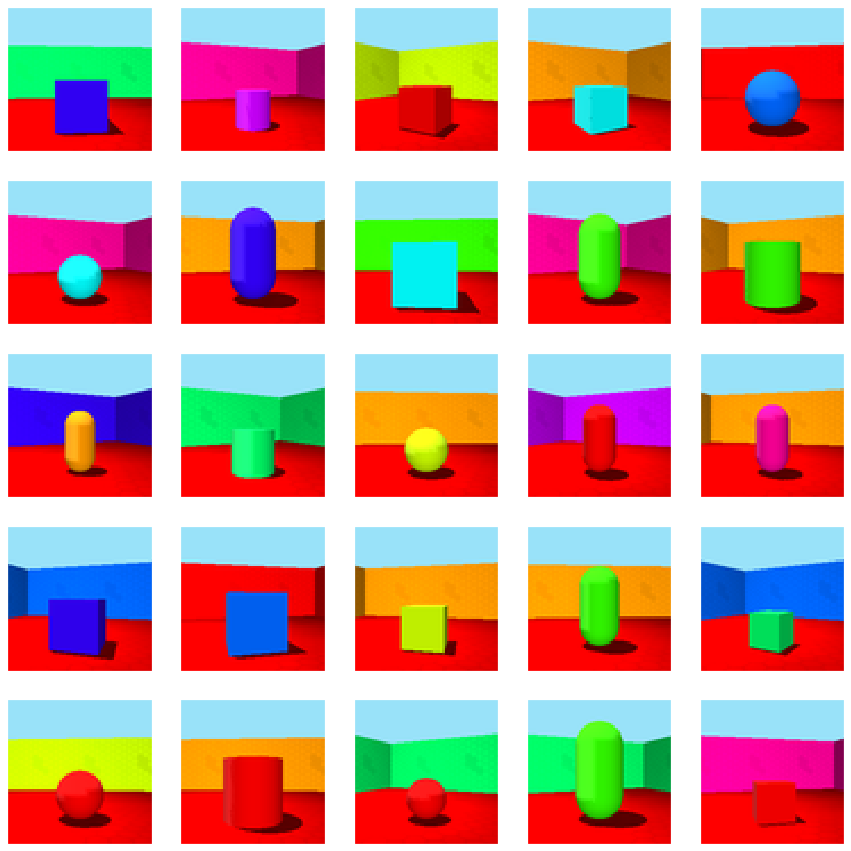

In [ ]:
batch_size = 25
fixed_factor_str = 'floor_hue' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 0  # first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)

show_images_grid(img_batch)